Training Master Model with 30 features...

MODEL PERFORMANCE
ROC AUC Score: 0.9735

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1637
           1       0.96      0.91      0.94      2754

    accuracy                           0.92      4391
   macro avg       0.91      0.93      0.92      4391
weighted avg       0.93      0.92      0.92      4391


 TOP 10 CRITICAL REPAIRS
           wpdx_id    status_clean           water_tech_clean   age  \
4430  6GGPVWQ6+Q4C  Non-Functional  Motorized Pump - Electric  17.0   
6181  6GGP3RV9+GCR  Non-Functional  Motorized Pump - Electric  17.0   
6712  6GGP3RVG+CV7  Non-Functional  Motorized Pump - Electric  17.0   
5114  6GGP3RVH+52F  Non-Functional  Motorized Pump - Electric  17.0   
3237  6GFPFPVW+CC9  Non-Functional  Motorized Pump - Electric  17.0   
4483  6GGP2MXR+FGG  Non-Functional  Motorized Pump - Electric  17.0   
6709  6GGP3RRH+9JP  Non-Functional  Motoriz

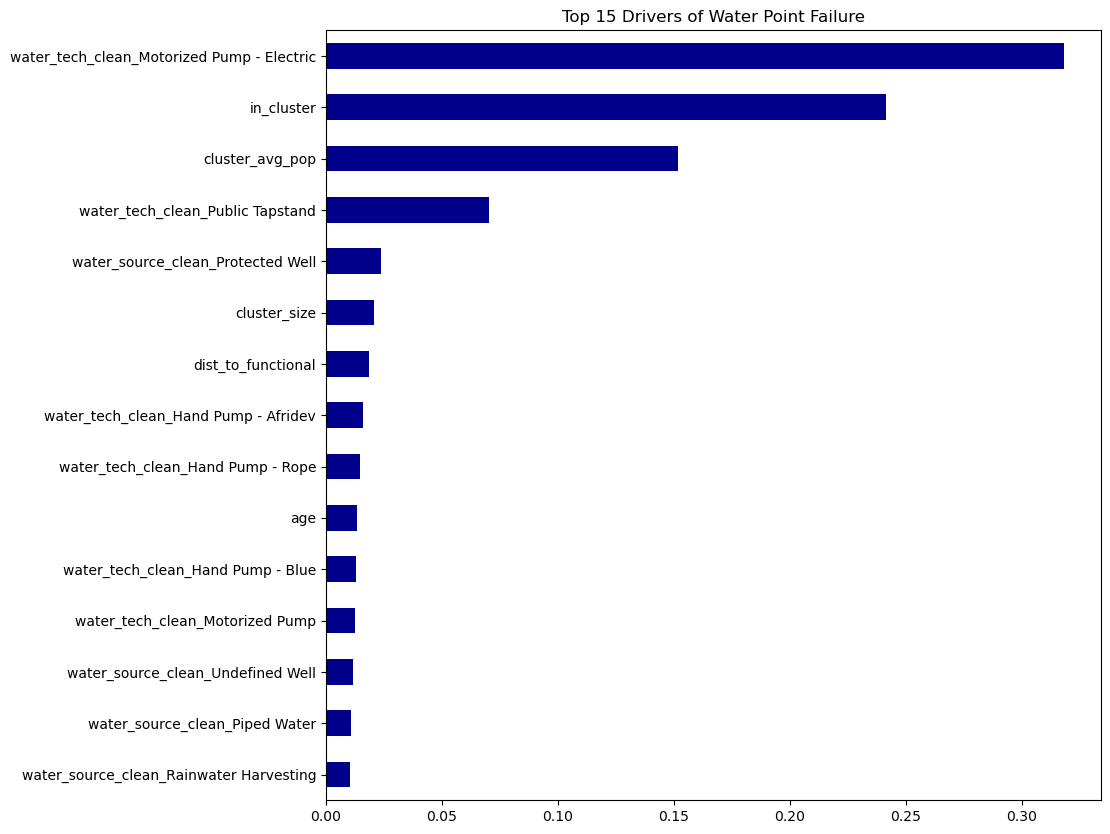


Found 12064 points with >85.0% failure risk
Saved high-risk GeoJSON to: I:\GEO DATA ANALYSIS\Kenya Water\nairobi_water_project\high_risk_points.geojson


Map(center=[0.5, 34.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from scipy.spatial import KDTree

# 1. Load Data
csv_path = r"I:\GEO DATA ANALYSIS\Kenya Water\nairobi_water_project\water_points_ml_clean.csv"
df = pd.read_csv(csv_path)

# --- 2. Feature Engineering ---

# Improved Target: 1 if Non-Functional, Abandoned, or Dry Season
df['target'] = df['status_clean'].str.contains(
    'Non-Functional|Abandoned|dry season', case=False, na=False
).astype(int)

# Age: Using 2026 as current year; median imputation
df['age'] = 2026 - df['install_year']
df['age'] = df['age'].fillna(df['age'].median())

# Spatial Feature: Distance to nearest functional neighbor
func_coords = df[df['target'] == 0][['lat_deg', 'lon_deg']].values
tree = KDTree(func_coords)
distances, _ = tree.query(df[['lat_deg', 'lon_deg']].values, k=2)
df['dist_to_functional'] = [d[1] if t == 0 else d[0] for d, t in zip(distances, df['target'])]

# Cluster Features
df['in_cluster'] = df['cluster_id'].notnull().astype(int)
df['cluster_size'] = df.groupby('cluster_id')['cluster_id'].transform('count').fillna(0)
df['cluster_avg_pop'] = df.groupby('cluster_id')['pop_served_500m'].transform('mean').fillna(0)

# Categorical Encoding: Tech & Source
# One-hot encode the most important categories
df_encoded = pd.get_dummies(df, columns=['water_source_clean', 'water_tech_clean', 'is_urban'], drop_first=True)

# --- 3. Model Training ---

# Identify all numeric/encoded features automatically
exclude_cols = ['wpdx_id', 'lat_deg', 'lon_deg', 'status_clean', 'geometry', 'geom_wkt', 'target', 'install_year', 'cluster_id']
features = [col for col in df_encoded.columns if col not in exclude_cols]

X = df_encoded[features]
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(
    n_estimators=300,      # Increased for complexity
    learning_rate=0.05,
    max_depth=7,           # Slightly deeper to capture interactions
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

print(f"Training Master Model with {len(features)} features...")
model.fit(X_train, y_train)

# --- 4. Final Evaluation ---

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n" + "="*40)
print("MODEL PERFORMANCE")
print("="*40)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 5. High-Risk Prioritization ---

df['failure_risk_score'] = model.predict_proba(X)[:, 1]

print("\n TOP 10 CRITICAL REPAIRS")
print(df[['wpdx_id', 'status_clean', 'water_tech_clean', 'age', 'failure_risk_score']]
      .sort_values('failure_risk_score', ascending=False)
      .head(10))

# Save for GIS use
df.to_csv('master_water_risk_prioritization.csv', index=False)

# --- 6. Visualization ---

# Feature Importance Plot
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkblue')
plt.title('Top 15 Drivers of Water Point Failure')
plt.show()



# --- 7. Create and Save High-Risk GeoJSON ---
# Filter high-risk points
high_risk_threshold = 0.85  # adjust as needed (0.7 or 0.9 also fine)
high_risk = df[df['failure_risk_score'] > high_risk_threshold].copy()

print(f"\nFound {len(high_risk)} points with >{high_risk_threshold*100}% failure risk")

# Create GeoDataFrame using lat/lon columns
high_risk_gdf = gpd.GeoDataFrame(
    high_risk,
    geometry=gpd.points_from_xy(high_risk['lon_deg'], high_risk['lat_deg']),
    crs="EPSG:4326"
)

# Save as GeoJSON
high_risk_geojson_path = r"I:\GEO DATA ANALYSIS\Kenya Water\nairobi_water_project\high_risk_points.geojson"
high_risk_gdf.to_file(high_risk_geojson_path, driver="GeoJSON")

print(f"Saved high-risk GeoJSON to: {high_risk_geojson_path}")



# Final Map
high_risk = df[df['failure_risk_score'] > 0.85].copy() # Higher threshold for the Master Model
gdf_high_risk = gpd.GeoDataFrame(
    high_risk, 
    geometry=gpd.points_from_xy(high_risk['lon_deg'], high_risk['lat_deg']),
    crs="EPSG:4326"
)

m = leafmap.Map(center=[0.5, 34.8], zoom=8)
m.add_gdf(gdf_high_risk, layer_name="Priority 1: High Risk (>85%)", 
          style={"color": "red", "fillColor": "red", "radius": 6})
m

In [8]:
# Filter to Nairobi 
import geopandas as gpd
import leafmap

# Create GeoDataFrame from full df
full_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon_deg'], df['lat_deg']),
    crs="EPSG:4326"
)

# Filter high-risk first
high_risk_threshold = 0.5  # temporary - to see if any points appear
high_risk_gdf = full_gdf[full_gdf['failure_risk_score'] > high_risk_threshold].copy()
print(f"Total high-risk points (>50%): {len(high_risk_gdf)}")

# Nairobi approximate bounding box (very accurate for most purposes)
# Wider & more accurate Nairobi bounds
min_lon, max_lon = 36.60, 37.10
min_lat, max_lat = -1.50, -1.10

nairobi_high_risk_gdf = high_risk_gdf[
    (high_risk_gdf.geometry.x >= 36.60) & (high_risk_gdf.geometry.x <= 37.10) &
    (high_risk_gdf.geometry.y >= -1.50) & (high_risk_gdf.geometry.y <= -1.10)
].copy()

print(f"Points in Nairobi bounds (>50%): {len(nairobi_high_risk_gdf)}")

# Save Nairobi-specific high-risk GeoJSON
nairobi_geojson_path = r"I:\GEO DATA ANALYSIS\Kenya Water\nairobi_water_project\high_risk_nairobi.geojson"
nairobi_high_risk_gdf.to_file(nairobi_geojson_path, driver="GeoJSON")

print(f"Saved to: {nairobi_geojson_path}")

# Quick interactive map (Nairobi zoom)
m = leafmap.Map(center=[-1.286, 36.817], zoom=11)  # Nairobi center
m.add_gdf(
    nairobi_high_risk_gdf,
    layer_name="High Risk in Nairobi (>85%)",
    style={"color": "red", "fillColor": "red", "radius": 6}
)
m.add_layer_control()
m

Total high-risk points (>50%): 13014
Points in Nairobi bounds (>50%): 2
Saved to: I:\GEO DATA ANALYSIS\Kenya Water\nairobi_water_project\high_risk_nairobi.geojson


Map(center=[-1.286, 36.817], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [9]:
# All points in Nairobi bounds (not just high-risk)
nairobi_all_gdf = full_gdf[
    (full_gdf.geometry.x >= 36.60) & (full_gdf.geometry.x <= 37.10) &
    (full_gdf.geometry.y >= -1.50) & (full_gdf.geometry.y <= -1.10)
].copy()

print(f"Total points in Nairobi bounds: {len(nairobi_all_gdf)}")
print("Risk score stats in Nairobi:")
print(nairobi_all_gdf['failure_risk_score'].describe())

# Show top 10 highest risk points in Nairobi (even if <50%)
print("\nTop 10 highest risk points in Nairobi bounds:")
print(nairobi_all_gdf[['wpdx_id', 'status_clean', 'water_tech_clean', 'age', 'failure_risk_score']]
      .sort_values('failure_risk_score', ascending=False)
      .head(10))

Total points in Nairobi bounds: 259
Risk score stats in Nairobi:
count    259.000000
mean       0.064449
std        0.091007
min        0.002013
25%        0.012773
50%        0.031881
75%        0.074718
max        0.623223
Name: failure_risk_score, dtype: float64

Top 10 highest risk points in Nairobi bounds:
            wpdx_id                status_clean  water_tech_clean   age  \
11147  6GCRRJ6J+C96                  Functional    Motorized Pump  17.0   
11228  6GCRVR49+93Q                  Functional    Motorized Pump  17.0   
20443  6GCRGJFG+Q6Q              Non-Functional         Hand Pump  17.0   
2357   6GCRJM25+H27                  Functional  Hand Pump - Rope  17.0   
20450  6GCRRXVM+V23              Non-Functional    Motorized Pump  36.0   
11220  6GCRVJRJ+937  Non-Functional, dry season    Motorized Pump  36.0   
20449  6GCRRMX9+2J3              Non-Functional    Motorized Pump  36.0   
11186  6GCRRWW5+8PP                  Functional    Motorized Pump  17.0   
9765   6GCRR